# 분석 프로그래밍 팀 프로젝트 코드
















# 데이터 불러오기 및 전처리

In [1]:
import pandas as pd #판다스 패키지
import numpy as np #넘파이 패키지

import seaborn as sns #시각화 패키지
import matplotlib.pylab as plt #시각화 패키지
from matplotlib import cm #시각화 패키지에서 컬러 조정

import sys
print(sys.version)

from scipy import stats
from scipy.stats import trim_mean
from statsmodels import robust #머신러닝 패키지

from sklearn.cluster import KMeans  # k-means 군집분석
from sklearn.metrics import silhouette_score  # 군집분석 평가를 위한 silhouette 값 계산
from IPython.display import Image #이미지 넣는 모듈

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name) #한글안나올때 넣는 모듈
plt.rcParams['axes.unicode_minus'] = False # 폰트 안나올때
# plt.rc('font', family='AppleGothic') # for MAC OS users
plt.rc('font', family=font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()) # for Windows OS user

In [2]:
tr = pd.read_csv(r"구매내역정보.csv", encoding='cp949')
cs = pd.read_csv(r"Demo.csv", encoding='cp949')
df = pd.merge(tr, cs, on = "ID")
display(df.head())

In [3]:
# 거주지역 분할
df['거주지역_광역'] = df['거주지역'].apply(lambda x : x.split(' ')[0])
df['거주지역_기초'] = df['거주지역'].apply(lambda x : x.split(' ')[1])

# 구매지역 분할
df['구매지역_광역'] = df['구매지역'].apply(lambda x : x.split(' ')[0])
df['구매지역_기초'] = df['구매지역'].apply(lambda x : x.split(' ')[1])

# 연령대 분할후
df['연령대'] = df['연령'].apply(lambda x : '50대' if x <60 else '60대' if x <70 else '70대' if x <80 else '80대')

# 성별 구분
df['성별'] = df['성별'].apply(lambda x : '남자' if x ==1 else '여자')

# 구매일자 구분
df['구매일자'] = df['구매일자'].astype(str).astype('datetime64') # 날짜정보를 담고 있는 de_dt 컬럼의 데이터 유형이 정수이기 때문
df['연'] = df['구매일자'].dt.year
df['월'] = df['구매일자'].dt.month
df["요일"] = df["구매일자"].apply(lambda x: ('월','화','수','목','금','토','일')[x.weekday()] + '요일')

# 판매단가 컬럼 생성
df['판매단가'] = (df['구매금액']/df['구매수량']).astype('int')

display(df.head())

,ID,상품대분류명,상품중분류명,구매지역,구매일자,구매시간,구매수량,구매금액,취소여부,성별,...,거주지역,거주지역_광역,거주지역_기초,구매지역_광역,구매지역_기초,연령대,연,월,요일,판매단가
0,410362886,의류잡화,여성용의류-정장류,서울 송파구,2014-05-10,1,1,198000,0,남자,...,부산 영도구,부산,영도구,서울,송파구,60대,2014,5,토요일,198000
1,410362886,식품,가공식품,서울 영등포구,2014-08-09,10,1,3000,0,남자,...,부산 영도구,부산,영도구,서울,영등포구,60대,2014,8,토요일,3000
2,410362886,식품,가공식품,서울 영등포구,2014-10-04,10,2,12000,0,남자,...,부산 영도구,부산,영도구,서울,영등포구,60대,2014,10,토요일,6000
3,410362886,식품,농산물,서울 영등포구,2014-08-09,10,1,1000,0,남자,...,부산 영도구,부산,영도구,서울,영등포구,60대,2014,8,토요일,1000
4,410362886,식품,수산물,서울 영등포구,2014-10-04,10,1,13000,0,남자,...,부산 영도구,부산,영도구,서울,영등포구,60대,2014,10,토요일,13000


# RFM 분석

### frequency

In [4]:
frequency = df.groupby("ID")["구매일자"].nunique().sort_values().reset_index()
frequency

,ID,구매일자
0,760598172,1
1,69323801,1
2,374540276,1
3,251281639,1
4,913527966,1
...,...,...
3537,622672192,106
3538,800536581,113
3539,56493915,115
3540,708674796,125


### monetary

In [5]:
from scipy.stats import norm

monetary = df.groupby("ID")["구매금액"].nunique().sort_values().reset_index()
monetary.구매금액.apply(lambda x: np.log1p(x))
monetary

,ID,구매금액
0,877896137,1
1,881718184,1
2,152045144,1
3,543881454,1
4,281948614,1
...,...,...
3537,647610673,170
3538,808654096,173
3539,467105964,173
3540,709252477,186


### recency

In [6]:
now = df.구매일자.max()+pd.DateOffset(days=1)
recency = (df.groupby('ID')['구매일자']
           .agg(lambda x,y: (y - x).min().days, now).reset_index()
           .rename(columns={'구매일자':'recency'})
          )

recency["recency"] = 365 - recency["recency"] 
recency

,ID,recency
0,741463,90
1,909249,358
2,1065068,362
3,1310410,284
4,1387032,334
...,...,...
3537,998623524,362
3538,999024423,323
3539,999184958,288
3540,999375162,354


## rfm score

In [7]:
rfm = pd.merge(frequency, monetary, on = "ID").merge(recency, on = "ID").set_index("ID")
rfm = (rfm/(rfm.max()))
rfm =rfm.rename(columns = {"구매일자":"frequency", "구매금액":"monetary"})

In [8]:
rfm["score"] = rfm["frequency"] * rfm["recency"] * rfm["monetary"]
rfm = rfm.reset_index()

In [9]:
rfm["등급"] = 0
for i in range(0, len(rfm["score"])):
    if rfm["score"][i] <= rfm["score"].quantile(1/3):
        rfm["등급"][i] = "3등급"
    elif rfm["score"][i] <= rfm["score"].quantile(2/3):
        rfm["등급"][i] = "2등급"
    else:
        rfm["등급"][i] = "1등급"
        
rfm = rfm[["ID", "등급"]]

<ipython-input-9-04e6b3f7503c>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm["등급"][i] = "3등급"
C:\Users\USER\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
<ipython-input-9-04e6b3f7503c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm["등급"][i] = "2등급"
<ipython-input-9-04e6b3f7503c>:8: SettingWithCopyWarning: 
A value is trying 

# RFM등급별 대분류제품군별 총구매액

In [10]:
df = df.merge(rfm, on = "ID")

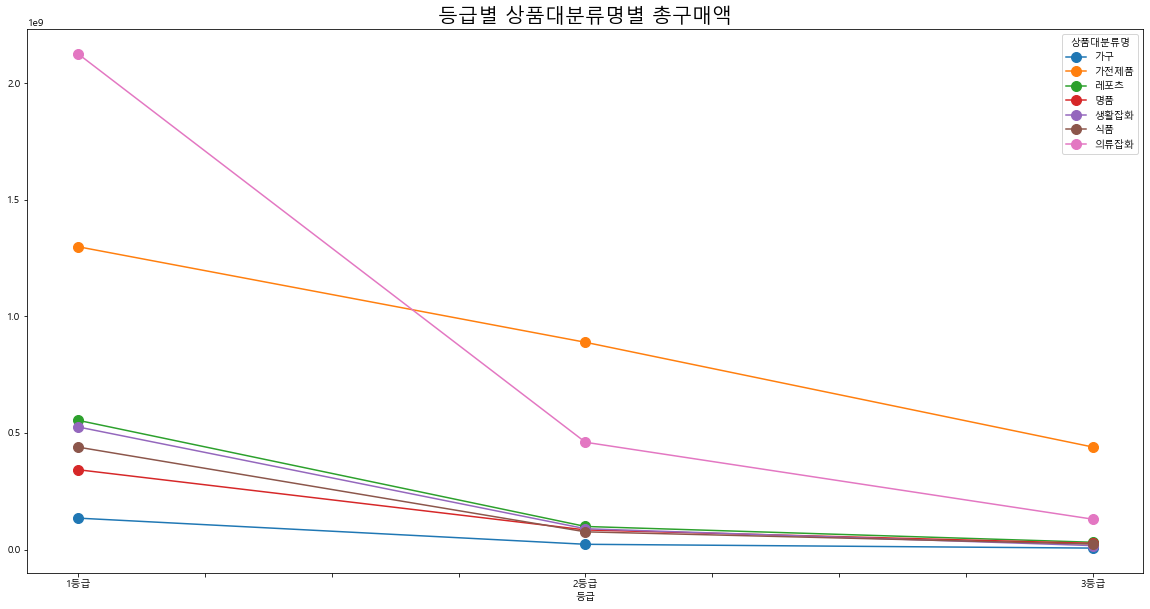

In [11]:
aa = pd.pivot_table(df, index = "등급", columns = "상품대분류명",
                values = "구매금액", aggfunc = "sum", fill_value = 0).plot(marker = "o", markersize = 10, figsize = (20, 10))
plt.title("등급별 상품대분류명별 총구매액", fontsize = 20)
plt.show()

## RFM등급별 상품중분류별 총구매액

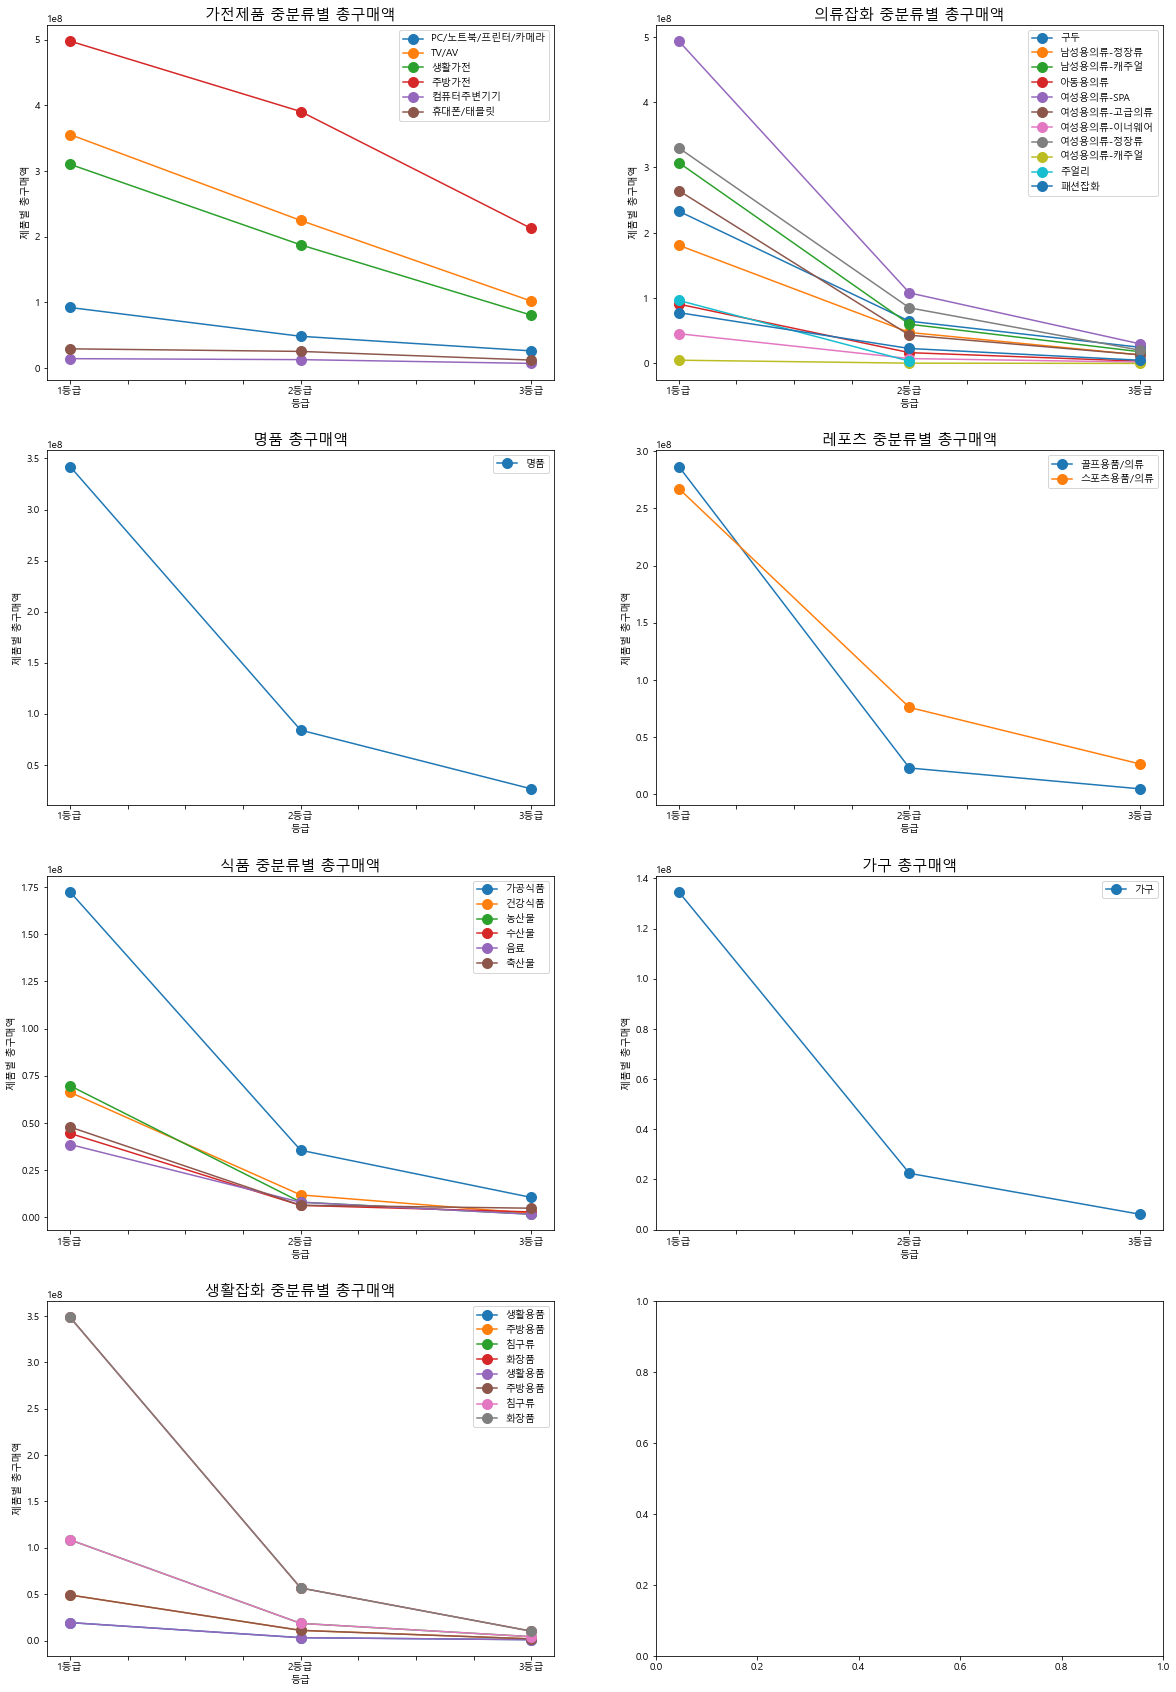

In [12]:
fig, axes = plt.subplots(4, 2, figsize = (20, 30))


pd.pivot_table(df.query("상품대분류명 == '가전제품'"), index = "등급", 
               columns = "상품중분류명", values = "구매금액", aggfunc = "sum").plot(marker = "o", markersize = 10, ax = axes[0, 0])
axes[0, 0].set_title("가전제품 중분류별 총구매액", fontsize = 15)
axes[0, 0].set_ylabel("제품별 총구매액")
axes[0, 0].legend(loc = "upper right")

pd.pivot_table(df.query("상품대분류명 == '의류잡화'"), index = "등급", 
               columns = "상품중분류명", values = "구매금액", aggfunc = "sum").plot(marker = "o", markersize = 10, ax = axes[0, 1])
axes[0, 1].set_title("의류잡화 중분류별 총구매액", fontsize = 15)
axes[0, 1].set_ylabel("제품별 총구매액")
axes[0, 1].legend(loc = "upper right")

pd.pivot_table(df.query("상품대분류명 == '명품'"), index = "등급", 
               columns = "상품중분류명", values = "구매금액", aggfunc = "sum").plot(marker = "o", markersize = 10, ax = axes[1, 0])
axes[1, 0].set_title("명품 총구매액", fontsize = 15)
axes[1, 0].set_ylabel("제품별 총구매액")
axes[1, 0].legend(loc = "upper right")

pd.pivot_table(df.query("상품대분류명 == '레포츠'"), index = "등급", 
               columns = "상품중분류명", values = "구매금액", aggfunc = "sum").plot(marker = "o", markersize = 10, ax = axes[1, 1])
axes[1, 1].set_title("레포츠 중분류별 총구매액", fontsize = 15)
axes[1, 1].set_ylabel("제품별 총구매액")
axes[1, 1].legend(loc = "upper right")

pd.pivot_table(df.query("상품대분류명 == '식품'"), index = "등급", 
               columns = "상품중분류명", values = "구매금액", aggfunc = "sum").plot(marker = "o", markersize = 10, ax = axes[2, 0])
axes[2, 0].set_title("식품 중분류별 총구매액", fontsize = 15)
axes[2, 0].set_ylabel("제품별 총구매액")
axes[2, 0].legend(loc = "upper right")

pd.pivot_table(df.query("상품대분류명 == '가구'"), index = "등급", 
               columns = "상품중분류명", values = "구매금액", aggfunc = "sum").plot(marker = "o", markersize = 10, ax = axes[2, 1])
axes[2, 1].set_title("가구 총구매액", fontsize = 15)
axes[2, 1].set_ylabel("제품별 총구매액")
axes[2, 1].legend(loc = "upper right")

pd.pivot_table(df.query("상품대분류명 == '생활잡화'"), index = "등급", 
               columns = "상품중분류명", values = "구매금액", aggfunc = "sum").plot(marker = "o", markersize = 10, ax = axes[3, 0])
axes[3, 0].set_title("생활잡화 중분류별 총구매액", fontsize = 15)
axes[3, 0].set_ylabel("제품별 총구매액")
axes[3, 0].legend(loc = "upper right")

pd.pivot_table(df.query("상품대분류명 == '생활잡화'"), index = "등급", 
               columns = "상품중분류명", values = "구매금액", aggfunc = "sum").plot(marker = "o", markersize = 10, ax = axes[3, 0])
axes[3, 0].set_title("생활잡화 중분류별 총구매액", fontsize = 15)
axes[3, 0].set_ylabel("제품별 총구매액")
axes[3, 0].legend(loc = "upper right")

plt.show()

# 이상치 제거

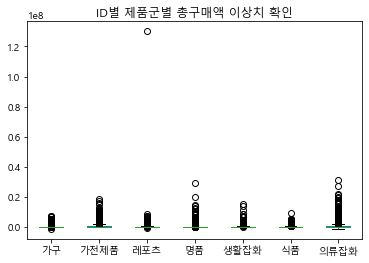

In [13]:
pd.pivot_table(df, index = "ID", columns = "상품대분류명", values = "구매금액", aggfunc = "sum", fill_value = 0).plot.box()
plt.title("ID별 제품군별 총구매액 이상치 확인")
plt.show()

In [14]:
df.query("상품대분류명 == '레포츠'").groupby("ID")["구매금액"].sum().sort_values(ascending = False).index[0]

700882892

In [15]:
#이상치 제거
idx = df[df["ID"]==700882892].index
df = df.drop(idx)

# 군집분석

### [Feature 1] 총구매액, 구매건수, 평균구매액, 최대구매액

In [16]:
features = df.groupby('ID')['구매금액'].agg([
    ('총구매액',np.sum), 
    ('구매건수', np.size), 
    ('평균구매액', lambda x: np.round(np.mean(x))),
    ('최대구매액', np.max),
]).reset_index()
features

,ID,총구매액,구매건수,평균구매액,최대구매액
0,741463,560000,7,80000,133000
1,909249,640000,29,22069,999000
2,1065068,1103000,11,100273,577000
3,1310410,249000,2,124500,196000
4,1387032,113000,6,18833,38000
...,...,...,...,...,...
3536,998623524,2088000,19,109895,887000
3537,999024423,25000,3,8333,17000
3538,999184958,3147000,26,121038,832000
3539,999375162,10762000,50,215240,6047000


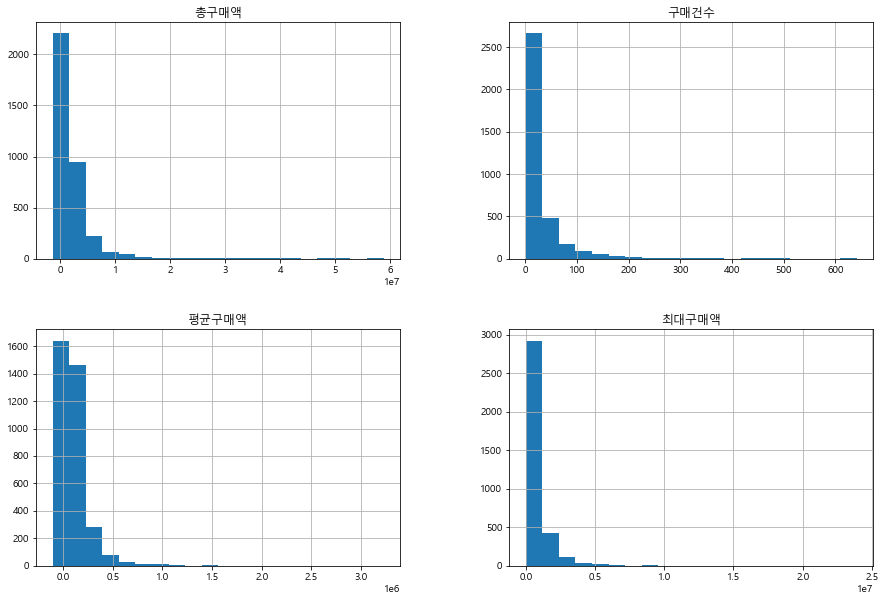

In [17]:
features.iloc[:,1:].hist(bins=20, figsize=(15,10))
plt.show()

In [18]:
df['구매일자']=df.구매일자.astype(str).astype('datetime64')

### [Feature 2] 내점일수, 구매주기, 주말방문율

In [19]:
f = df.groupby("ID")['구매일자'].agg([('내점일수',lambda x: x.nunique()),('구매주기', lambda x : int(((x.max() - x.min()).days) / x.nunique())),('주말방문율', lambda x: (x.dt.weekday > 4).mean().round(2)) 
]).reset_index()
features = features.merge(f, how='left'); features

,ID,총구매액,구매건수,평균구매액,최대구매액,내점일수,구매주기,주말방문율
0,741463,560000,7,80000,133000,6,12,0.14
1,909249,640000,29,22069,999000,18,18,0.48
2,1065068,1103000,11,100273,577000,5,35,0.18
3,1310410,249000,2,124500,196000,2,133,1.00
4,1387032,113000,6,18833,38000,4,79,0.17
...,...,...,...,...,...,...,...,...
3536,998623524,2088000,19,109895,887000,11,28,0.11
3537,999024423,25000,3,8333,17000,3,62,0.33
3538,999184958,3147000,26,121038,832000,7,39,0.19
3539,999375162,10762000,50,215240,6047000,14,25,0.30


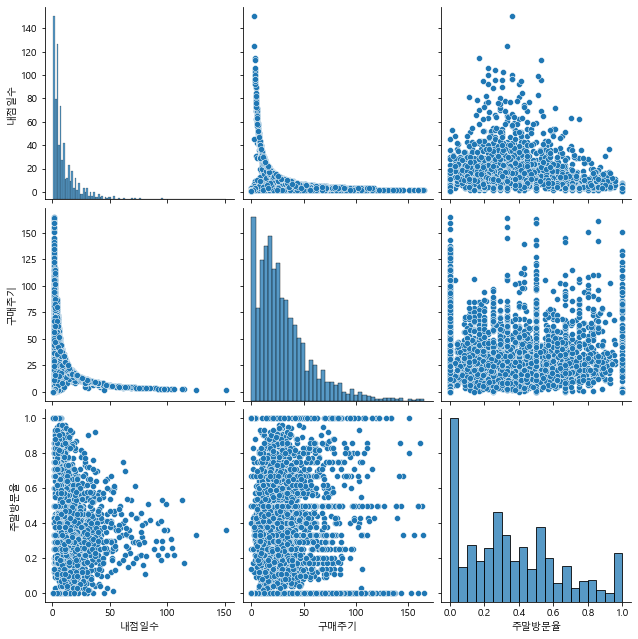

In [20]:
sns.pairplot(data=f.iloc[:,1:], height=3)
plt.show()

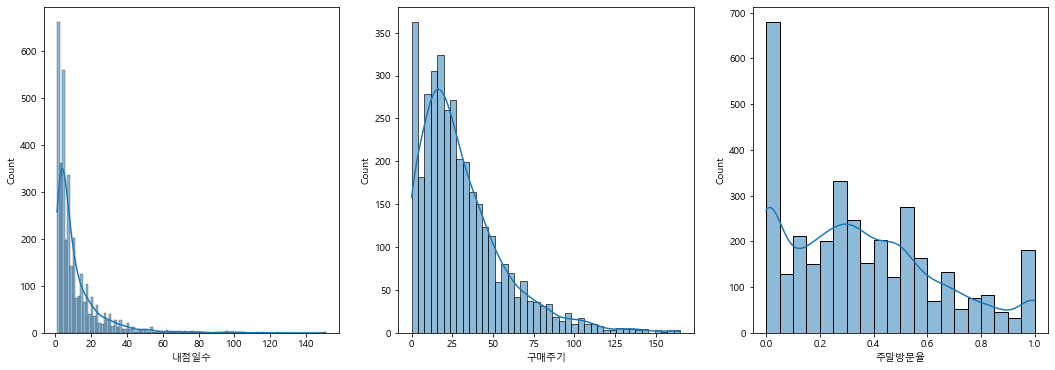

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))

sns.histplot(data=f, x='내점일수', kde=True, ax=ax[0])
sns.histplot(data=f, x='구매주기', kde=True, ax=ax[1])
sns.histplot(data=f, x='주말방문율', kde=True, ax=ax[2])
plt.show()

### [Feature3] 거래 당 평균 구매액, 구매건수

In [22]:
visit_cnt = df.groupby('ID')['구매일자'].agg(lambda x: x.nunique()) #롯데에서 구매한 사실 자체만 집중. 
per_amount = (df.groupby('ID')['구매금액'].sum() / visit_cnt).round(0).reset_index().rename(columns={0:'거래당구매액'})
per_count = (df.groupby('ID')['구매금액'].count() / visit_cnt).round(1).reset_index().rename(columns={0:'거래당구매건수'})

f= pd.merge(per_amount, per_count, on='ID')
features = features.merge(f, how='left'); features

,ID,총구매액,구매건수,평균구매액,최대구매액,내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수
0,741463,560000,7,80000,133000,6,12,0.14,93333.0,1.2
1,909249,640000,29,22069,999000,18,18,0.48,35556.0,1.6
2,1065068,1103000,11,100273,577000,5,35,0.18,220600.0,2.2
3,1310410,249000,2,124500,196000,2,133,1.00,124500.0,1.0
4,1387032,113000,6,18833,38000,4,79,0.17,28250.0,1.5
...,...,...,...,...,...,...,...,...,...,...
3536,998623524,2088000,19,109895,887000,11,28,0.11,189818.0,1.7
3537,999024423,25000,3,8333,17000,3,62,0.33,8333.0,1.0
3538,999184958,3147000,26,121038,832000,7,39,0.19,449571.0,3.7
3539,999375162,10762000,50,215240,6047000,14,25,0.30,768714.0,3.6


### [Feature4]주구매시간

In [23]:
pd.DataFrame(df.query("ID == '999375162'")["구매시간"]).value_counts()

구매시간
16      15
14      11
15       7
19       4
13       4
12       3
20       2
18       2
17       2
dtype: int64

In [24]:
f = df.groupby('ID')['구매시간'].agg([('주구매시간', lambda x: int(x.value_counts().index[0]))]).reset_index()
features= features.merge(f, how="left"); features

,ID,총구매액,구매건수,평균구매액,최대구매액,내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,주구매시간
0,741463,560000,7,80000,133000,6,12,0.14,93333.0,1.2,13
1,909249,640000,29,22069,999000,18,18,0.48,35556.0,1.6,11
2,1065068,1103000,11,100273,577000,5,35,0.18,220600.0,2.2,19
3,1310410,249000,2,124500,196000,2,133,1.00,124500.0,1.0,17
4,1387032,113000,6,18833,38000,4,79,0.17,28250.0,1.5,13
...,...,...,...,...,...,...,...,...,...,...,...
3536,998623524,2088000,19,109895,887000,11,28,0.11,189818.0,1.7,13
3537,999024423,25000,3,8333,17000,3,62,0.33,8333.0,1.0,15
3538,999184958,3147000,26,121038,832000,7,39,0.19,449571.0,3.7,14
3539,999375162,10762000,50,215240,6047000,14,25,0.30,768714.0,3.6,16


<AxesSubplot:xlabel='count', ylabel='주구매시간'>

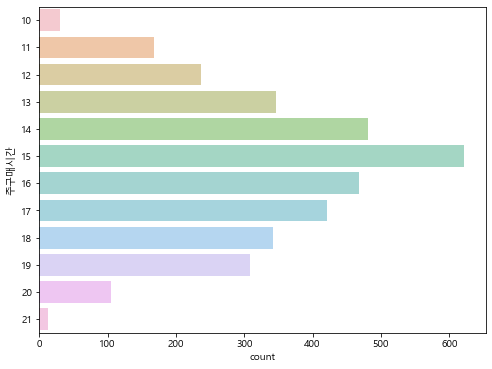

In [25]:
# 범주형 속성 값의 빈도 출력
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(y='주구매시간', data=f, alpha=0.5)  

### [Feature5]가격선호도

In [26]:
# 판매단가 계산
df['price'] = df['구매금액'] / df['구매수량']

# 상품중분류별 평균 판매단가에 대한 4분위수 계산 => 3Q 이상을 고가상품으로 설정
price_4q = df.groupby('상품중분류명')['price'].mean().quantile([.25,.5,.75])
pd.DataFrame(price_4q)

,price
0.25,52283.876442
0.50,89805.705537
0.75,204530.190295


In [27]:
f = (df.groupby('ID')['price']
     .agg([('고가상품구매율', lambda x: (x > price_4q.iloc[2]).mean().round(2))])
     .reset_index())
features = features.merge(f, how='left')
features.sort_values(by=['고가상품구매율'], ascending=False)

,ID,총구매액,구매건수,평균구매액,최대구매액,내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,주구매시간,고가상품구매율
390,100063272,1945000,1,1945000,1945000,1,0,0.00,1945000.0,1.0,14,1.0
1415,406502232,814000,2,407000,562000,1,0,0.00,814000.0,2.0,17,1.0
1470,419763560,6456000,2,3228000,6039000,2,19,0.50,3228000.0,1.0,11,1.0
3322,950709087,275000,1,275000,275000,1,0,0.00,275000.0,1.0,15,1.0
563,157674952,779000,2,389500,390000,1,0,0.00,779000.0,2.0,15,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2084,596780720,162000,4,40500,64000,1,0,0.00,162000.0,4.0,18,0.0
2083,596457166,97000,2,48500,80000,1,0,1.00,97000.0,2.0,14,0.0
2082,595883106,1785000,38,46974,186000,16,20,0.37,111562.0,2.4,14,0.0
2081,595868543,377000,13,29000,123000,5,52,0.31,75400.0,2.6,12,0.0


### [Feature6]구매추세

In [28]:
# 마지막주부터 10주전까지 (총 10주 간) 매주 구매건수를 계산하여 리스트에 넣음
week_to = df.구매일자.max()
week_trans = []
for i in range(10):
    week_from = week_to + pd.DateOffset(weeks=-1)
    week_trans.append(df.query('@week_from < 구매일자 <= @week_to')
                      .groupby('ID')['구매금액']
                      .agg([(f'w{10-i}', 'size')])
                      .reset_index())
    week_to = week_from

# 리스트로부터 데이터프레임 변환    
f = pd.DataFrame({'ID': df.ID.unique()})
for w in week_trans[::-1]:
    f = pd.merge(f, w, how='left')
f = f.fillna(0)

f['구매추세'] = f.apply(lambda x: np.polyfit(range(10), x[1:], 1)[0].round(2), axis=1)
features = features.merge(f.iloc[:,[0,-1]], how='left'); features

,ID,총구매액,구매건수,평균구매액,최대구매액,내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,주구매시간,고가상품구매율,구매추세
0,741463,560000,7,80000,133000,6,12,0.14,93333.0,1.2,13,0.00,0.00
1,909249,640000,29,22069,999000,18,18,0.48,35556.0,1.6,11,0.07,0.08
2,1065068,1103000,11,100273,577000,5,35,0.18,220600.0,2.2,19,0.09,0.15
3,1310410,249000,2,124500,196000,2,133,1.00,124500.0,1.0,17,0.00,0.00
4,1387032,113000,6,18833,38000,4,79,0.17,28250.0,1.5,13,0.00,-0.03
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3536,998623524,2088000,19,109895,887000,11,28,0.11,189818.0,1.7,13,0.11,0.13
3537,999024423,25000,3,8333,17000,3,62,0.33,8333.0,1.0,15,0.00,-0.06
3538,999184958,3147000,26,121038,832000,7,39,0.19,449571.0,3.7,14,0.19,0.00
3539,999375162,10762000,50,215240,6047000,14,25,0.30,768714.0,3.6,16,0.36,0.21


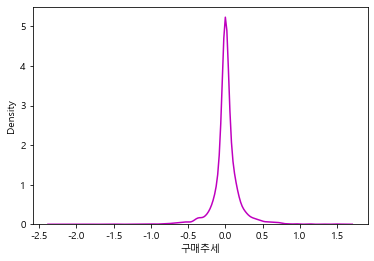

In [29]:
sns.kdeplot(f.구매추세, color='m')
plt.show()

### [Feature 7]취소건수

In [30]:
cancel_df = pd.DataFrame(df.groupby("ID")["취소여부"].agg([("취소건수",sum)]).reset_index())
features = pd.merge(features,cancel_df,how='left')
features

,ID,총구매액,구매건수,평균구매액,최대구매액,내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,주구매시간,고가상품구매율,구매추세,취소건수
0,741463,560000,7,80000,133000,6,12,0.14,93333.0,1.2,13,0.00,0.00,0
1,909249,640000,29,22069,999000,18,18,0.48,35556.0,1.6,11,0.07,0.08,6
2,1065068,1103000,11,100273,577000,5,35,0.18,220600.0,2.2,19,0.09,0.15,0
3,1310410,249000,2,124500,196000,2,133,1.00,124500.0,1.0,17,0.00,0.00,0
4,1387032,113000,6,18833,38000,4,79,0.17,28250.0,1.5,13,0.00,-0.03,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3536,998623524,2088000,19,109895,887000,11,28,0.11,189818.0,1.7,13,0.11,0.13,0
3537,999024423,25000,3,8333,17000,3,62,0.33,8333.0,1.0,15,0.00,-0.06,0
3538,999184958,3147000,26,121038,832000,7,39,0.19,449571.0,3.7,14,0.19,0.00,1
3539,999375162,10762000,50,215240,6047000,14,25,0.30,768714.0,3.6,16,0.36,0.21,9


### [Feature 8]액티브시니어 특징이 드러나는 상품중분류별 구매금액

In [31]:
a=df.query("상품중분류명 == '휴대폰/태블릿'").groupby("ID")["구매금액"].agg([("휴대폰/태블릿구매금액",sum)]).reset_index()
b=df.query("상품중분류명 == '화장품'").groupby("ID")["구매금액"].agg([("화장품구매금액",sum)]).reset_index()
c=df.query("상품대분류명 == '레포츠'").groupby("ID")["구매금액"].agg([("레포츠구매금액",sum)]).reset_index()
d=df.query("상품중분류명 == '여성용의류-SPA'").groupby("ID")["구매금액"].agg([("여성용의류-SPA구매금액",sum)]).reset_index()
e=df.query("상품중분류명 == '명품'").groupby("ID")["구매금액"].agg([("명품구매금액",sum)]).reset_index()
f=df.query("상품중분류명 == '가공식품'").groupby("ID")["구매금액"].agg([("가공식품구매금액",sum)]).reset_index()
g=df.query("상품대분류명 == '가전제품'").groupby("ID")["구매금액"].agg([("가전제품구매금액",sum)]).reset_index()
features = pd.merge(features, a, how='left')
features = pd.merge(features, b, how='left')
features = pd.merge(features, c, how='left')
features = pd.merge(features, d, how='left')
features = pd.merge(features, e, how='left')
features = pd.merge(features, f, how='left')
features = pd.merge(features, g, how='left')

features = features.fillna(0)
features



,ID,총구매액,구매건수,평균구매액,최대구매액,내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,...,고가상품구매율,구매추세,취소건수,휴대폰/태블릿구매금액,화장품구매금액,레포츠구매금액,여성용의류-SPA구매금액,명품구매금액,가공식품구매금액,가전제품구매금액
0,741463,560000,7,80000,133000,6,12,0.14,93333.0,1.2,...,0.00,0.00,0,0.0,0.0,320000.0,0.0,0.0,0.0,0.0
1,909249,640000,29,22069,999000,18,18,0.48,35556.0,1.6,...,0.07,0.08,6,0.0,0.0,122000.0,0.0,0.0,46000.0,83000.0
2,1065068,1103000,11,100273,577000,5,35,0.18,220600.0,2.2,...,0.09,0.15,0,0.0,679000.0,0.0,0.0,0.0,22000.0,271000.0
3,1310410,249000,2,124500,196000,2,133,1.00,124500.0,1.0,...,0.00,0.00,0,0.0,196000.0,0.0,53000.0,0.0,0.0,0.0
4,1387032,113000,6,18833,38000,4,79,0.17,28250.0,1.5,...,0.00,-0.03,0,0.0,0.0,0.0,0.0,0.0,75000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3536,998623524,2088000,19,109895,887000,11,28,0.11,189818.0,1.7,...,0.11,0.13,0,0.0,77000.0,0.0,0.0,0.0,12000.0,1455000.0
3537,999024423,25000,3,8333,17000,3,62,0.33,8333.0,1.0,...,0.00,-0.06,0,0.0,0.0,0.0,2000.0,0.0,0.0,23000.0
3538,999184958,3147000,26,121038,832000,7,39,0.19,449571.0,3.7,...,0.19,0.00,1,0.0,0.0,0.0,249000.0,495000.0,9000.0,950000.0
3539,999375162,10762000,50,215240,6047000,14,25,0.30,768714.0,3.6,...,0.36,0.21,9,0.0,0.0,0.0,527000.0,6127000.0,86000.0,58000.0


### 상관계수(-1 ~ +1)를 통해 feature 간의 유사성을 파악

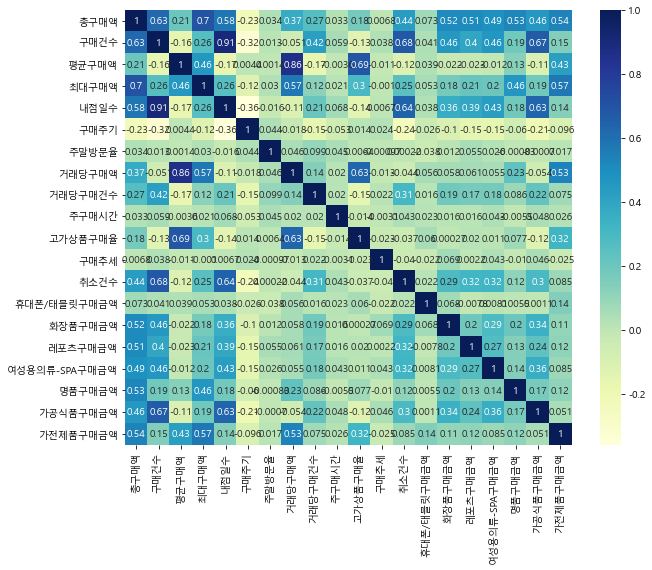

In [32]:
plt.figure(figsize=(10,8))
sns.heatmap(features.iloc[:,1:].corr(), annot=True, cmap="YlGnBu")
plt.show()

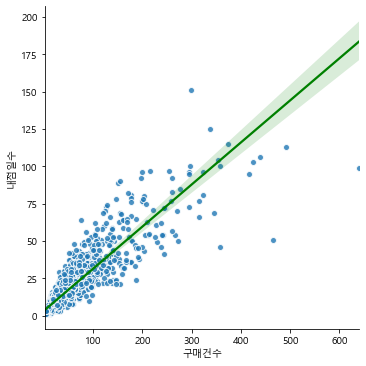

In [33]:
# 양의 상관관계가 매우 높음.
sns.lmplot(x='구매건수', y='내점일수', data=features, 
           line_kws={'color':"green"}, scatter_kws={'edgecolor':"white"})
plt.show()

### 불필요한 feature 삭제

In [34]:
features = features.drop(columns='평균구매액')
features = features.drop(columns='구매건수')

### 표준화

In [35]:
X = features.iloc[:,1:].apply(lambda x: (x - x.mean()) / x.std()) 
X

,총구매액,최대구매액,내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,주구매시간,고가상품구매율,구매추세,취소건수,휴대폰/태블릿구매금액,화장품구매금액,레포츠구매금액,여성용의류-SPA구매금액,명품구매금액,가공식품구매금액,가전제품구매금액
0,-0.441248,-0.549027,-0.382841,-0.708959,-0.755768,-0.473623,-0.919037,-1.013705,-0.787631,-0.063513,-0.388573,-0.174208,-0.207406,0.355339,-0.305699,-0.136722,-0.404380,-0.521807
1,-0.419284,0.255671,0.457389,-0.482879,0.435855,-0.677783,-0.555082,-1.853558,-0.410622,0.358438,0.600716,-0.174208,-0.207406,-0.074785,-0.305699,-0.136722,-0.102417,-0.463304
2,-0.292172,-0.136457,-0.452860,0.157679,-0.615577,-0.023916,-0.009148,1.505853,-0.302906,0.727645,-0.388573,-0.174208,0.993496,-0.339811,-0.305699,-0.136722,-0.259963,-0.330792
3,-0.526630,-0.490487,-0.662918,3.850307,2.258337,-0.363493,-1.101015,0.666000,-0.787631,-0.063513,-0.388573,-0.174208,0.139246,-0.339811,-0.214858,-0.136722,-0.404380,-0.521807
4,-0.563967,-0.637303,-0.522880,1.815594,-0.650625,-0.703599,-0.646071,-1.013705,-0.787631,-0.221745,-0.388573,-0.174208,-0.207406,-0.339811,-0.305699,-0.136722,0.087951,-0.521807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3536,-0.021749,0.151599,-0.032745,-0.106080,-0.860911,-0.132687,-0.464093,-1.013705,-0.195189,0.622157,-0.388573,-0.174208,-0.071221,-0.339811,-0.305699,-0.136722,-0.325607,0.503752
3537,-0.588127,-0.656816,-0.592899,1.175036,-0.089861,-0.773977,-1.101015,-0.173853,-0.787631,-0.379976,-0.388573,-0.174208,-0.207406,-0.339811,-0.302271,-0.136722,-0.404380,-0.505595
3538,0.268989,0.100492,-0.312822,0.308398,-0.580529,0.785169,1.355687,-0.593779,0.235678,-0.063513,-0.223691,-0.174208,-0.207406,-0.339811,0.121080,0.392753,-0.345300,0.147802
3539,2.359618,4.946335,0.177312,-0.219120,-0.195004,1.912885,1.264698,0.246074,1.151269,1.044108,1.095361,-0.174208,-0.207406,-0.339811,0.597564,6.416996,0.160160,-0.480925


## 최적 군집 수(K) 도출

### 군집 수에 따른 SSE(군집내 오차제곱합) 계산

In [36]:
wss = []
sis = []
for k in range(2,10):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X)
    wss = np.append(wss, kmeans.inertia_)

### 군집 수에 따른 SSE 시각화

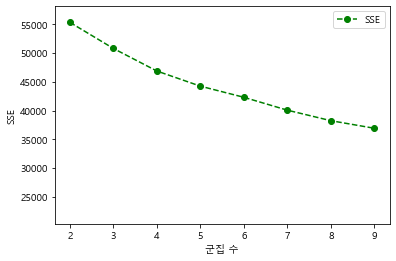

In [37]:
fig, ax = plt.subplots()
line = ax.plot(np.arange(2,10), wss, 'go--', label='SSE')
ax.set_ylim(wss.min()*0.55, wss.max()*1.05)
ax.set_xlabel('군집 수')
ax.set_ylabel('SSE')
labels = [l.get_label() for l in line]
plt.legend(line, labels)
plt.show()

In [38]:
#wss비교
wss
for i in range(0, 7):
    print(wss[i] - wss[i+1])

4534.403799557476
3922.9285589345745
2627.80900168074
1935.105425437505
2239.981515441388
1826.0220761313758
1317.794514917572


In [39]:
best_k = 3

In [40]:
kmeans = KMeans(n_clusters=best_k, random_state=0)
kmeans.fit(X)

KMeans(n_clusters=3, random_state=0)

In [41]:
features['세그먼트'] = kmeans.labels_
features

,ID,총구매액,최대구매액,내점일수,구매주기,주말방문율,거래당구매액,거래당구매건수,주구매시간,고가상품구매율,구매추세,취소건수,휴대폰/태블릿구매금액,화장품구매금액,레포츠구매금액,여성용의류-SPA구매금액,명품구매금액,가공식품구매금액,가전제품구매금액,세그먼트
0,741463,560000,133000,6,12,0.14,93333.0,1.2,13,0.00,0.00,0,0.0,0.0,320000.0,0.0,0.0,0.0,0.0,0
1,909249,640000,999000,18,18,0.48,35556.0,1.6,11,0.07,0.08,6,0.0,0.0,122000.0,0.0,0.0,46000.0,83000.0,0
2,1065068,1103000,577000,5,35,0.18,220600.0,2.2,19,0.09,0.15,0,0.0,679000.0,0.0,0.0,0.0,22000.0,271000.0,0
3,1310410,249000,196000,2,133,1.00,124500.0,1.0,17,0.00,0.00,0,0.0,196000.0,0.0,53000.0,0.0,0.0,0.0,0
4,1387032,113000,38000,4,79,0.17,28250.0,1.5,13,0.00,-0.03,0,0.0,0.0,0.0,0.0,0.0,75000.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3536,998623524,2088000,887000,11,28,0.11,189818.0,1.7,13,0.11,0.13,0,0.0,77000.0,0.0,0.0,0.0,12000.0,1455000.0,0
3537,999024423,25000,17000,3,62,0.33,8333.0,1.0,15,0.00,-0.06,0,0.0,0.0,0.0,2000.0,0.0,0.0,23000.0,0
3538,999184958,3147000,832000,7,39,0.19,449571.0,3.7,14,0.19,0.00,1,0.0,0.0,0.0,249000.0,495000.0,9000.0,950000.0,0
3539,999375162,10762000,6047000,14,25,0.30,768714.0,3.6,16,0.36,0.21,9,0.0,0.0,0.0,527000.0,6127000.0,86000.0,58000.0,1


### 군집분석을 통한 고객 세분화

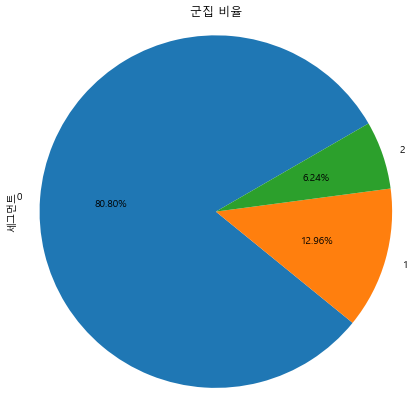

In [42]:
plt.figure(figsize=(6,6))
features.세그먼트.value_counts().plot.pie(autopct='%.2f%%', figsize=(7,7), 
                                      startangle=30, legend=False)
plt.title("군집 비율")
plt.axis('equal')
plt.show()

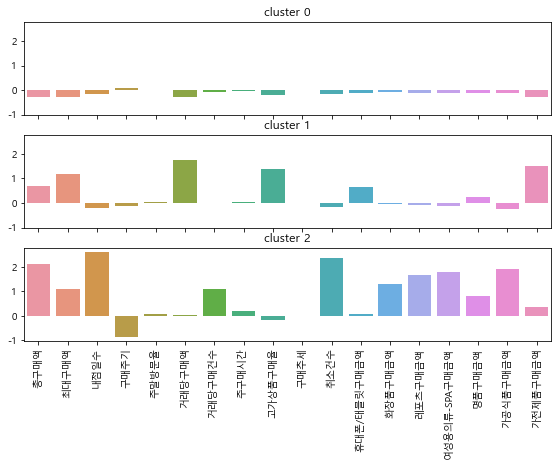

In [43]:
fig, ax = plt.subplots(best_k, 1, figsize=(8,5), sharex=True, sharey=True)
ax = ax.ravel()
plt.tight_layout() # 자동으로 레이아웃 조정

for i in range(kmeans.n_clusters):
    ax[i].set_title('cluster %d' % i)
    sns.barplot(x=np.arange(X.columns.size), y=kmeans.cluster_centers_[i], ax=ax[i])
    ax[i].set_xticks(np.arange(X.columns.size))
    ax[i].set_xticklabels(X.columns, rotation=90)

# 군집2의 우수성

In [44]:
df = df.merge(features[["ID", "세그먼트"]], on = "ID")

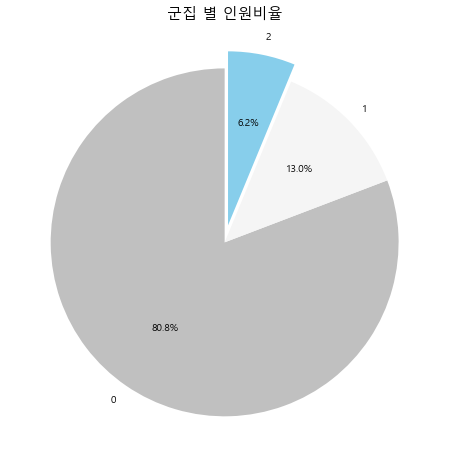

In [45]:
#세그먼트 비율
df.groupby("세그먼트")["ID"].nunique().plot.pie(startangle = 90, explode = [0, 0, 0.1], 
                                            autopct = "%1.1f%%", figsize = (8, 8), colors =  ['silver', 'whitesmoke', 'skyblue'])
plt.ylabel("")
plt.title("군집 별 인원비율", fontsize = 15)
plt.show()

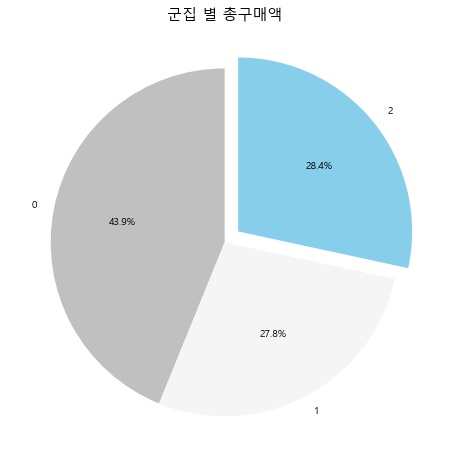

In [46]:
#군집 별 구매액비율
df.groupby("세그먼트")["구매금액"].sum().plot.pie(startangle = 90, explode = [0, 0, 0.1],
                                          autopct = "%1.1f%%", figsize = (8, 8), colors =  ['silver', 'whitesmoke', 'skyblue'])
plt.ylabel("")
plt.title("군집 별 총구매액", fontsize = 15)
plt.show()

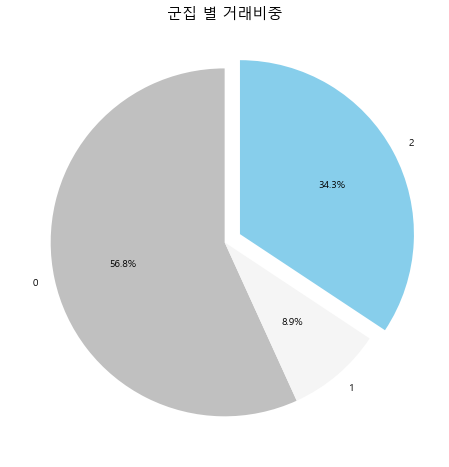

In [47]:
#군집 별 구매액비율
df.groupby("세그먼트")["구매수량"].count().plot.pie(startangle = 90, explode = [0, 0, 0.1],
                                            autopct = "%1.1f%%", figsize = (8, 8), colors =  ['silver', 'whitesmoke', 'skyblue'])
plt.ylabel("")
plt.title("군집 별 거래비중", fontsize = 15)
plt.show()

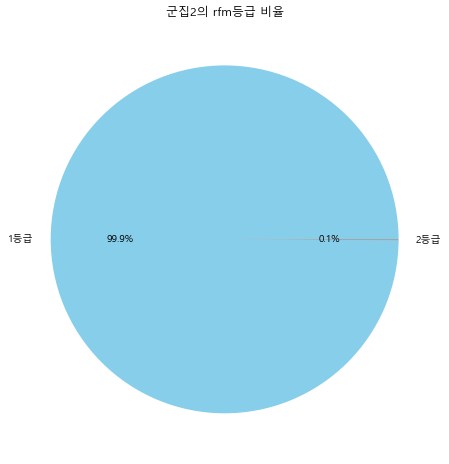

In [48]:
df.query("세그먼트 == '2'").등급.value_counts().plot.pie(figsize = (8, 8), autopct = "%1.1f%%", colors = ["skyblue", "gray"])
plt.title("군집2의 rfm등급 비율")
plt.ylabel("")
plt.show()

# 타겟시장 구매행태 데이터 분석

In [49]:
vip = df.query("세그먼트 == '2'")

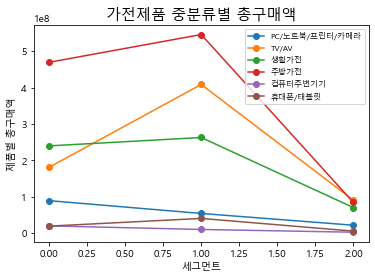

In [50]:
# 군집별 가전제품 총구매액
pd.pivot_table(df.query("상품대분류명 == '가전제품'"), index = "세그먼트", 
               columns = "상품중분류명", values = "구매금액", aggfunc = "sum").plot(marker = "o", markersize = 6)
plt.title("가전제품 중분류별 총구매액", fontsize = 15)
plt.ylabel("제품별 총구매액")
plt.legend(loc = "upper right",fontsize=8)
plt.show()

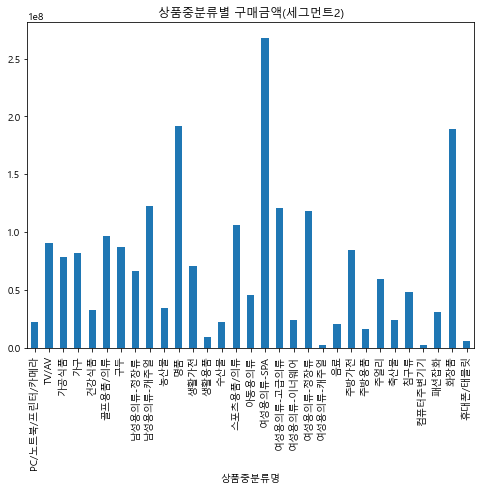

In [51]:
df.query('세그먼트==2').groupby('상품중분류명')['구매금액'].sum().plot(kind='bar', figsize = (8, 6))
plt.title('상품중분류별 구매금액(세그먼트2)')
plt.show()

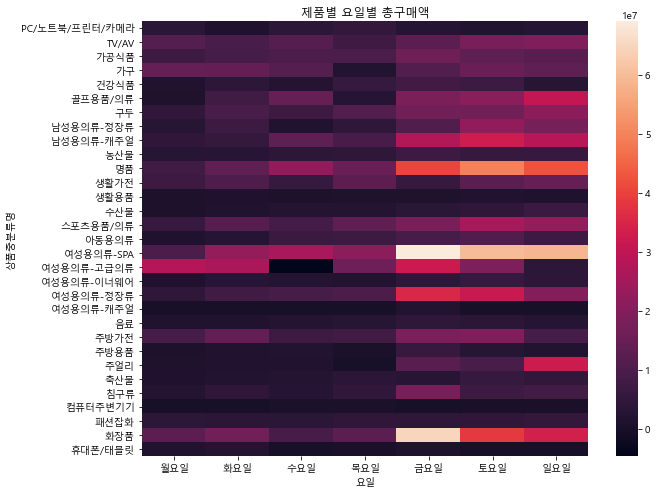

In [52]:
# 요일별 제품군별 총구매액
a = pd.pivot_table(vip, index = "상품중분류명", columns = "요일", values = "구매금액", aggfunc = "sum", fill_value = 0).T
a = a.reindex(['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일'])
plt.figure(figsize=(10,8))
sns.heatmap(a.T)
plt.title("제품별 요일별 총구매액")
plt.show()

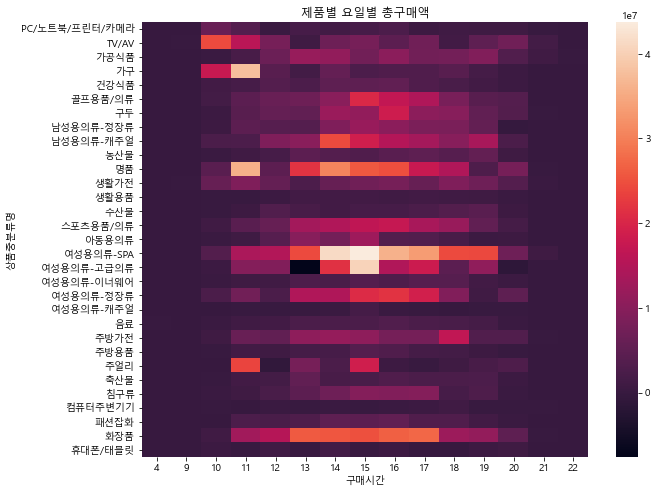

In [53]:
# 제품별 요일별 총구매액
b = pd.pivot_table(vip, index = "상품중분류명", columns = "구매시간", values = "구매금액", aggfunc = "sum", fill_value = 0)
plt.figure(figsize=(10,8))
sns.heatmap(b)
plt.title("제품별 요일별 총구매액")
plt.show()

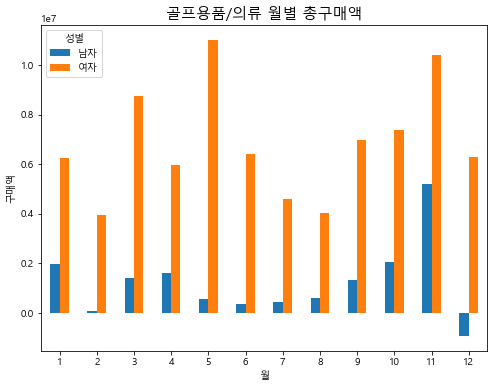

In [54]:
# 월별 레포츠 상품의 총구매액 비교

pd.pivot_table(vip.query("상품중분류명 == '골프용품/의류'"), index = "월", columns = "성별", 
               values = "구매금액", aggfunc = "sum", fill_value = 0).plot.bar(figsize = (8, 6), rot = 0)
plt.title("골프용품/의류 월별 총구매액", fontsize = 15)
plt.ylabel("구매액")
plt.xlabel("월")
plt.show()

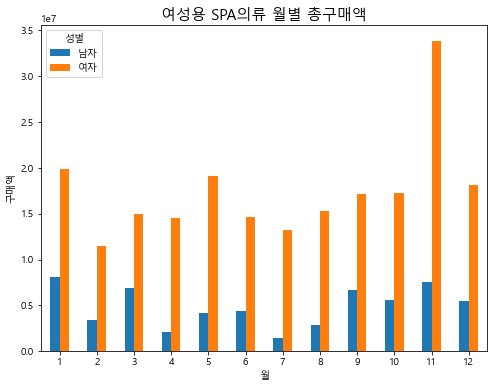

In [55]:
# 월별 레포츠 상품의 총구매액 비교

pd.pivot_table(vip.query("상품중분류명 == '여성용의류-SPA'"), index = "월", columns = "성별", 
               values = "구매금액", aggfunc = "sum", fill_value = 0).plot.bar(figsize = (8, 6), rot = 0)
plt.title("여성용 SPA의류 월별 총구매액", fontsize = 15)
plt.ylabel("구매액")
plt.xlabel("월")
plt.show()

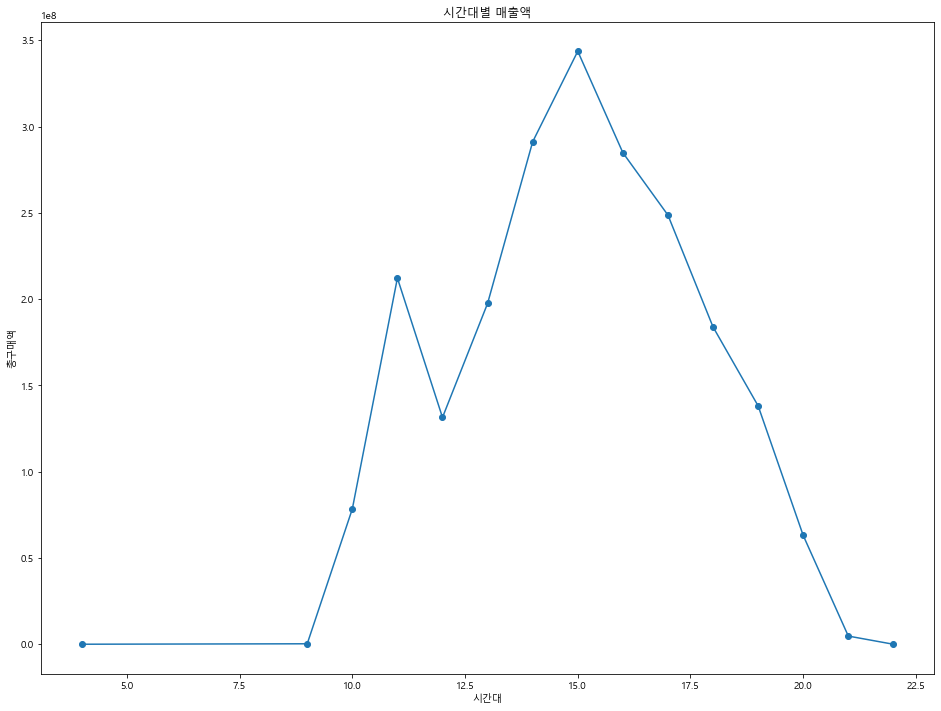

In [56]:
# 전체 상품의 시간대별 구매액

vip.groupby("구매시간")["구매금액"].sum().plot(marker = "o", figsize = (16, 12))
plt.xlabel("시간대")
plt.ylabel("총구매액")
plt.title("시간대별 매출액")
plt.show()

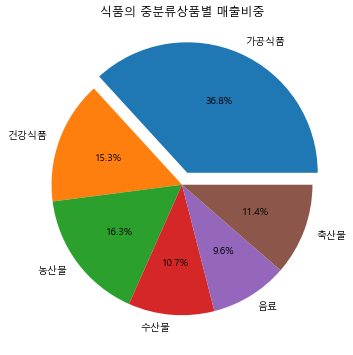

In [57]:
# 식품의 중분류상품별 매출비중

f = vip.query("상품대분류명 == '식품'")
f.groupby("상품중분류명")["구매금액"].sum().plot.pie(autopct = "%1.1f%%", explode = [0.1, 0, 0, 0, 0, 0], figsize = (6, 6))
plt.title("식품의 중분류상품별 매출비중")
plt.ylabel("")
plt.show()

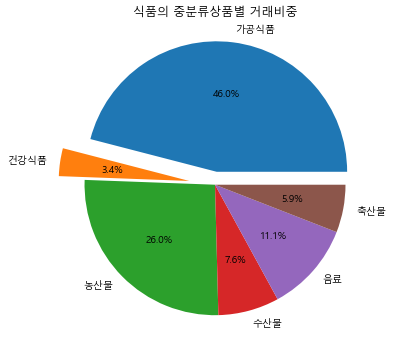

In [58]:
# 식품의 중분류상품별 거래비중

f = vip.query("상품대분류명 == '식품'")
f.groupby("상품중분류명")["구매금액"].count().plot.pie(autopct = "%1.1f%%", explode = [0.1, 0.2, 0, 0, 0, 0], figsize = (6, 6))
plt.title("식품의 중분류상품별 거래비중")
plt.ylabel("")
plt.show()

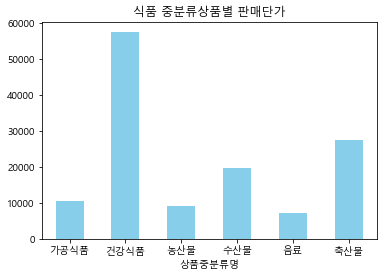

In [59]:
# 식품별 판매단가의 평균

f.groupby("상품중분류명")["판매단가"].mean().plot.bar(rot = 0, color = "skyblue")
plt.title("식품 중분류상품별 판매단가")
plt.show()